In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Descargamos el dataset con el precio de Tesla
tesla_df = yf.download('TSLA', start = '2013-02-01', end = '2021-01-27', progress = False)

In [3]:
tesla_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-20,858.739990,859.500000,837.280029,850.450012,850.450012,25665900
2021-01-21,855.000000,855.719971,841.419983,844.989990,844.989990,20598100
2021-01-22,834.309998,848.000000,828.619995,846.640015,846.640015,20066500
2021-01-25,855.000000,900.400024,838.820007,880.799988,880.799988,41173400
2021-01-26,891.380005,895.900024,871.599976,883.090027,883.090027,23131600


In [4]:
tesla_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-02-01,7.634,7.700,7.524,7.660,7.660,5503000
2013-02-04,7.680,7.684,7.518,7.548,7.548,5640000
2013-02-05,7.600,7.730,7.536,7.626,7.626,6551000
2013-02-06,7.636,7.878,7.580,7.834,7.834,9466000
2013-02-07,7.838,7.936,7.790,7.896,7.896,5983000


In [76]:
len(tesla_df)

2008

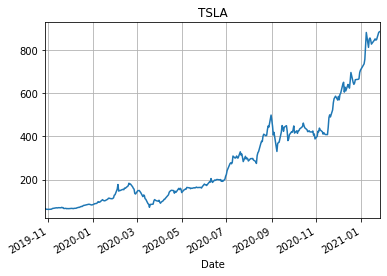

In [3]:
#Graficamos el precio
ticker = yf.Ticker('TSLA')
tesla_ticker = ticker.history(period = '15mo') #1mo, mas reciente. A medida que aumentamos, aumentamos el espacio temporal. max es todo el historial
tesla_ticker['Close'].plot(title = 'TSLA').grid(True)

In [32]:
#tomamos el precio de cierre para usar en el modelo
tesla_df_close = tesla_df['Close']

In [12]:
type(tesla_df_close)

pandas.core.series.Series

In [33]:
tesla_df_close.shape

(2009,)

In [8]:
def normalicer(chart):
    import numpy as np
    
    norm = np.linalg.norm(chart)
    chart_norm = chart/norm
    
    return chart_norm, norm

def no_normalice(chart, norm):
    chart_nonorm = chart * norm
    
    return chart_nonorm

#probando MinMax
def minMax(chart):
    from sklearn.preprocessing import MinMaxScaler
    import joblib as jl
    #Escalamos y guardamos scaler para posterior uso
    scaler = MinMaxScaler()
    scaler.fit(chart)
    scaled = scaler.transform(chart)
    jl.dump(scaled ,'/Users/jmaxi/DataScience/Notebooks de apuntes/Portafolio/VanillaLSTM/scaler.pkl')
    #Transofrmamos en DataFrame otra vez
    col_name = ['Open', 'High', 'Low', 'Close', 'Adj close', 'Volume']
    chartt = pd.DataFrame(scaled, columns = col_name)
    
    return chartt

In [9]:
tsla_norm = minMax(tesla_df)

In [10]:
tsla_norm.head()

,Open,High,Low,Close,Adj close,Volume
0,0.000850,0.000792,0.000883,0.000895,0.000895,0.010916
1,0.000902,0.000775,0.000876,0.000767,0.000767,0.011369
2,0.000812,0.000826,0.000897,0.000856,0.000856,0.014380
3,0.000852,0.000992,0.000948,0.001093,0.001093,0.024017
4,0.001081,0.001057,0.001191,0.001164,0.001164,0.012503


In [11]:
tsla_norm_close = tsla_norm['Close']

In [12]:
type(tsla_norm_close)

pandas.core.series.Series

In [25]:
#Serializamos
def to_sequences(seq_size, chart):
    x = []
    y = []

    for i in range(len(chart)-seq_size):
        #print(i)
        window = chart[i:(i+seq_size)]
        after_window = chart[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [26]:
#cortar un pedazo del dataset para hacer el RMSE
train = tsla_norm_close[:1526]
test = tsla_norm_close[1526:1908]
verificacion = tsla_norm_close[1908:]

n_steps = 10
#n_features_train = len(train)

X_train_norm, y_train_norm = to_sequences(n_steps,train)
X_test_norm, y_test_norm = to_sequences(n_steps,test)
X_ver_norm, y_ver_norm = to_sequences(n_steps, verificacion)

KeyError: 10

I got a key error but the algorithm works

#### Model

In [12]:
import tensorflow as tf

In [74]:
VanillaLSTM = tf.keras.models.Sequential()
VanillaLSTM.add(tf.keras.layers.LSTM(50, activation = 'relu', input_shape = (None,1))) #(n_steps, n_features)
VanillaLSTM.add(tf.keras.layers.Dense(1))

VanillaLSTM.compile(optimizer = 'adam', loss = 'mse')

In [75]:
VanillaLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [118]:
#Early stop
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights= True)

In [119]:
VanillaLSTM.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 700, callbacks = [callback])

Train on 1516 samples, validate on 372 samples
Epoch 1/700
1516/1516 [==============================] - 1s 418us/sample - loss: 2.5704 - val_loss: 76.5690
Epoch 2/700
1516/1516 [==============================] - 1s 408us/sample - loss: 2.5612 - val_loss: 111.9113
Epoch 3/700
1516/1516 [==============================] - 1s 411us/sample - loss: 2.4695 - val_loss: 71.1179
Epoch 4/700
1516/1516 [==============================] - 1s 413us/sample - loss: 2.1987 - val_loss: 98.3200
Epoch 5/700
1516/1516 [==============================] - 1s 397us/sample - loss: 2.3542 - val_loss: 94.6310
Epoch 6/700
1516/1516 [==============================] - 1s 404us/sample - loss: 2.5260 - val_loss: 97.5013
Epoch 7/700
1516/1516 [==============================] - 1s 408us/sample - loss: 2.3361 - val_loss: 91.7642
Epoch 8/700
1516/1516 [==============================] - 1s 404us/sample - loss: 2.2204 - val_loss: 92.5035


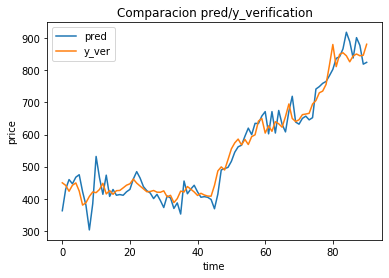

In [163]:
predVanillaLSTM = VanillaLSTM.predict(X_ver)
plt.plot(predVanillaLSTM)
plt.plot(y_ver)
plt.title('Comparacion pred/y_verification')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['pred', 'y_ver'], loc='upper left')
plt.show()

In [29]:
from sklearn import metrics

In [30]:
score = np.sqrt(metrics.mean_squared_error(pred, y_ver))
print("Score (RMSE): {}".format(score))

NameError: name 'pred' is not defined

In [33]:
train = tesla_df_close[:1526]
test = tesla_df_close[1526:1908]
verificacion = tesla_df_close[1908:]

n_steps = 10
#n_features_train = len(train)

X_train, y_train = to_sequences(n_steps,train)
X_test, y_test = to_sequences(n_steps,test)
X_ver, y_ver = to_sequences(n_steps, verificacion)

In [104]:
VanillaLSTM_2 = tf.keras.models.Sequential()
VanillaLSTM_2.add(tf.keras.layers.LSTM(100, activation = 'relu', input_shape = (None,1))) #(n_steps, n_features)
VanillaLSTM_2.add(tf.keras.layers.Dense(1))

VanillaLSTM_2.compile(optimizer = 'adam', loss = 'mse')

In [116]:
history = VanillaLSTM_2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 700, callbacks = [callback])

Train on 1516 samples, validate on 372 samples
Epoch 1/700
1516/1516 [==============================] - 0s 314us/sample - loss: 2.2423 - val_loss: 72.3426
Epoch 2/700
1516/1516 [==============================] - 0s 299us/sample - loss: 2.1570 - val_loss: 70.2886
Epoch 3/700
1516/1516 [==============================] - 0s 306us/sample - loss: 2.1646 - val_loss: 70.9211
Epoch 4/700
1516/1516 [==============================] - 0s 301us/sample - loss: 2.1183 - val_loss: 72.1866
Epoch 5/700
1516/1516 [==============================] - 0s 307us/sample - loss: 2.2539 - val_loss: 72.7327
Epoch 6/700
1516/1516 [==============================] - 0s 301us/sample - loss: 2.2971 - val_loss: 91.4010
Epoch 7/700
1516/1516 [==============================] - 0s 297us/sample - loss: 2.2114 - val_loss: 73.2671
Epoch 8/700
1516/1516 [==============================] - 0s 299us/sample - loss: 2.2190 - val_loss: 74.6792
Epoch 9/700
1516/1516 [==============================] - 0s 306us/sample - loss: 2.1739 -

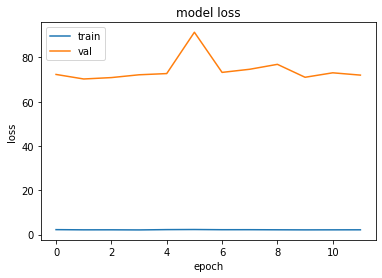

In [117]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [97]:
VanillaLSTM_2.save('/Users/jmaxi/DataScience/Notebooks de apuntes/Portafolio/VanillaLSTM/')

INFO:tensorflow:Assets written to: /Users/jmaxi/DataScience/Notebooks de apuntes/Portafolio/VanillaLSTM/assets


In [13]:
VanillaLSTM_2 = tf.keras.models.load_model('/Users/jmaxi/DataScience/Notebooks de apuntes/Portafolio/VanillaLSTM/')

In [16]:
predVanillaLSTM_2 = VanillaLSTM_2.predict(X_ver)

score = np.sqrt(metrics.mean_squared_error(predVanillaLSTM_2, y_ver))
print("Score (RMSE): {}".format(score))

Score (RMSE): 33.5066007433855


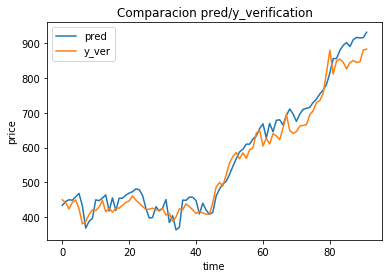

In [17]:
plt.plot(predVanillaLSTM_2)
plt.plot(y_ver)
plt.title('Comparacion pred/y_verification')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['pred', 'y_ver'], loc='upper left')
plt.show()

---

#### Stacked LSTM

In [138]:
StackedLSTM =  tf.keras.models.Sequential()
StackedLSTM.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(None,1)))
StackedLSTM.add(tf.keras.layers.LSTM(50, activation='relu'))
StackedLSTM.add(tf.keras.layers.Dense(1))
StackedLSTM.compile(optimizer='adam', loss='mse')

In [139]:
history_stacked = StackedLSTM.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 700, callbacks = [callback])

Train on 1516 samples, validate on 372 samples
Epoch 1/700
1516/1516 [==============================] - 4s 3ms/sample - loss: 115.7253 - val_loss: 1037.9584
Epoch 2/700
1516/1516 [==============================] - 1s 750us/sample - loss: 19.8452 - val_loss: 697.3680s - l
Epoch 3/700
1516/1516 [==============================] - 1s 737us/sample - loss: 15.9560 - val_loss: 1036.7621
Epoch 4/700
1516/1516 [==============================] - 1s 740us/sample - loss: 11.8298 - val_loss: 846.1035
Epoch 5/700
1516/1516 [==============================] - 1s 733us/sample - loss: 8.9080 - val_loss: 737.8736
Epoch 6/700
1516/1516 [==============================] - 1s 734us/sample - loss: 8.2648 - val_loss: 841.6743
Epoch 7/700
1516/1516 [==============================] - 1s 746us/sample - loss: 8.1214 - val_loss: 681.0811
Epoch 8/700
1516/1516 [==============================] - 1s 753us/sample - loss: 7.6546 - val_loss: 974.7184
Epoch 9/700
1516/1516 [==============================] - 1s 742us/sampl

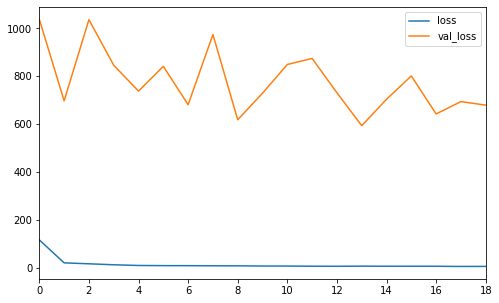

In [140]:
pd.DataFrame(history_stacked.history).plot(figsize=(8,5))
plt.show()

In [156]:
predStackedLSTM = StackedLSTM.predict(X_ver)

score = np.sqrt(metrics.mean_squared_error(predStackedLSTM, y_ver))
print("Score (RMSE): {}".format(score))

Score (RMSE): 93.94671296775049


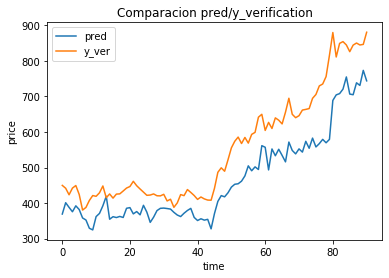

In [157]:
plt.plot(predStackedLSTM)
plt.plot(y_ver)
plt.title('Comparacion pred/y_verification')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['pred', 'y_ver'], loc='upper left')
plt.show()

---

#### Bidireccional LSTM

In [142]:
BiLSTM = tf.keras.models.Sequential()
BiLSTM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation = 'relu', input_shape = (None,1)))) #(n_steps, n_features)
BiLSTM.add(tf.keras.layers.Dense(1))

BiLSTM.compile(optimizer = 'adam', loss = 'mse')

In [143]:
history_bi = BiLSTM.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 700, callbacks = [callback])

Train on 1516 samples, validate on 372 samples
Epoch 1/700
1516/1516 [==============================] - 3s 2ms/sample - loss: 290.7313 - val_loss: 400.8295
Epoch 2/700
1516/1516 [==============================] - 1s 608us/sample - loss: 4.9076 - val_loss: 153.9892
Epoch 3/700
1516/1516 [==============================] - 1s 612us/sample - loss: 4.4704 - val_loss: 191.1679
Epoch 4/700
1516/1516 [==============================] - 1s 601us/sample - loss: 3.9621 - val_loss: 241.6521
Epoch 5/700
1516/1516 [==============================] - 1s 603us/sample - loss: 3.7495 - val_loss: 220.7405
Epoch 6/700
1516/1516 [==============================] - 1s 612us/sample - loss: 3.9243 - val_loss: 238.5647
Epoch 7/700
1516/1516 [==============================] - 1s 615us/sample - loss: 3.4739 - val_loss: 210.0201


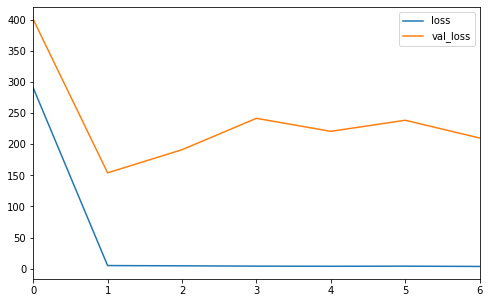

In [144]:
pd.DataFrame(history_bi.history).plot(figsize=(8,5))
plt.show()

In [152]:
predBiLSTM = BiLSTM.predict(X_ver)

score = np.sqrt(metrics.mean_squared_error(predBiLSTM, y_ver))
print("Score (RMSE): {}".format(score))

Score (RMSE): 50.50625870731166


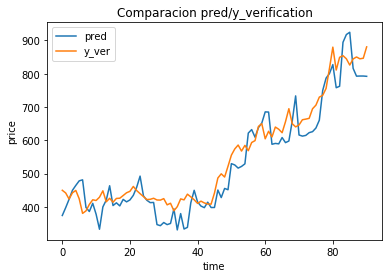

In [155]:
plt.plot(predBiLSTM)
plt.plot(y_ver)
plt.title('Comparacion pred/y_verification')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['pred', 'y_ver'], loc='upper left')
plt.show()

In [146]:
#Stacked Bi
BiLSTMs = tf.keras.models.Sequential()
BiLSTMs.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation = 'relu', input_shape = (None,1))))
BiLSTMs.add(tf.keras.layers.LSTM(50, activation='relu'))
BiLSTMs.add(tf.keras.layers.Dense(1))

BiLSTMs.compile(optimizer = 'adam', loss = 'mse')

In [147]:
history_bi_s = BiLSTM.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 700, callbacks = [callback])

Train on 1516 samples, validate on 372 samples
Epoch 1/700
1516/1516 [==============================] - 1s 806us/sample - loss: 4.1505 - val_loss: 205.5029
Epoch 2/700
1516/1516 [==============================] - 1s 606us/sample - loss: 3.7452 - val_loss: 272.8947
Epoch 3/700
1516/1516 [==============================] - 1s 623us/sample - loss: 4.0623 - val_loss: 250.3746
Epoch 4/700
1516/1516 [==============================] - 1s 585us/sample - loss: 3.3184 - val_loss: 196.0204
Epoch 5/700
1516/1516 [==============================] - 1s 613us/sample - loss: 3.0998 - val_loss: 217.0597
Epoch 6/700
1516/1516 [==============================] - 1s 589us/sample - loss: 3.1328 - val_loss: 210.4277
Epoch 7/700
1516/1516 [==============================] - 1s 594us/sample - loss: 3.2703 - val_loss: 210.1921
Epoch 8/700
1516/1516 [==============================] - 1s 601us/sample - loss: 2.6730 - val_loss: 244.8633
Epoch 9/700
1516/1516 [==============================] - 1s 604us/sample - loss: 

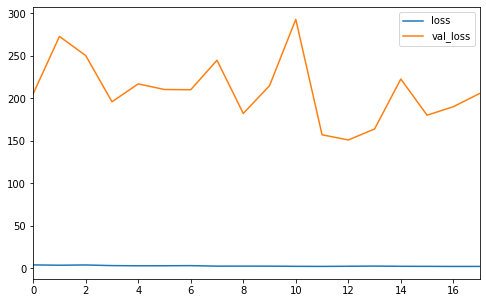

In [148]:
pd.DataFrame(history_bi_s.history).plot(figsize=(8,5))
plt.show()

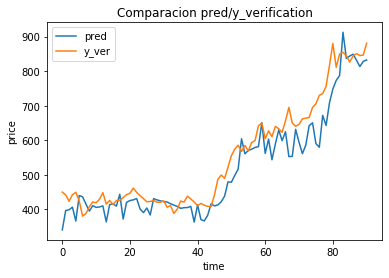

In [151]:
plt.plot(predBiLSTMs)
plt.plot(y_ver)
plt.title('Comparacion pred/y_verification')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['pred', 'y_ver'], loc='upper left')
plt.show()